In [11]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import glob
import cv2
import mmdet
from mmdet.apis import init_detector, inference_detector
from mmdet.datasets import replace_ImageToTensor, build_dataset, build_dataloader
from mmdet.datasets.pipelines import Compose
from mmdet.core import bbox_cxcywh_to_xyxy, bbox_xyxy_to_cxcywh, bbox_xyxy_to_cxcywh
from tqdm import tqdm
import pickle
from mmdet.core.bbox.iou_calculators.iou2d_calculator import BboxOverlaps2D
import lap
plt.rcParams['figure.dpi'] = 100

In [27]:
def _get_ece(preds, targets, n_bins=15):
    """
    ECE ported from Asukha et al., 2020.
    :param preds: Prediction probabilities in a Numpy array
    :param targets: Targets in a numpy array
    :param n_bins: Total number of bins to use.
    :return: Expected calibration error.
    """
    bin_boundaries = np.linspace(0, 1, n_bins + 1)
    bin_lowers = bin_boundaries[:-1]
    bin_uppers = bin_boundaries[1:]

    confidences, predictions = np.max(preds, 1), np.argmax(preds, 1)
    accuracies = (predictions == targets)

    ece = 0.0
    avg_confs_in_bins = []
    for bin_lower, bin_upper in zip(bin_lowers, bin_uppers):
        in_bin = np.logical_and(confidences > bin_lower, confidences <= bin_upper)
        prop_in_bin = np.mean(in_bin)
        if prop_in_bin > 0:
            accuracy_in_bin = np.mean(accuracies[in_bin])
            avg_confidence_in_bin = np.mean(confidences[in_bin])
            delta = avg_confidence_in_bin - accuracy_in_bin
            avg_confs_in_bins.append(delta)
            ece += np.abs(delta) * prop_in_bin
        else:
            avg_confs_in_bins.append(None)
    # For reliability diagrams, also need to return these:
    # return ece, bin_lowers, avg_confs_in_bins
    return ece

In [12]:
with open('base_detr_output.pkl', 'rb') as f:
    data = pickle.load(f)

In [13]:
def linear_assignment(cost_matrix):
    _, x, y = lap.lapjv(cost_matrix, extend_cost=True)
    matches = np.array([[y[i], i] for i in x if i >= 0])
    sort_idx = np.argsort(matches[:, 1])
    matches = matches[sort_idx]
    matches = torch.from_numpy(matches).long()
    return matches

In [67]:
all_probs, all_labels = [], []
count_unmatched = 0
count_no_preds = 0
total_gt_bboxes = 0

for sample in data:
    gt_bboxes = torch.from_numpy(sample['gt_bboxes'])
    gt_labels = torch.from_numpy(sample['gt_labels']).long()    
    probs = torch.from_numpy(sample['cls_probs'])[-1]
    is_bg = probs[:, -1] >= 0.5
    max_probs, _ = probs.max(-1)
    is_conf = max_probs >= 0.2
    
    mask = ~is_bg & is_conf
    probs = probs[mask]
    
    #scale and convert bbox preds to match gt format
    H, W, _ = sample['ori_shape']
    factor = torch.tensor([W, H, W, H]).unsqueeze(0)
    bbox_preds = torch.from_numpy(sample['bbox_preds'][-1]) 
    bbox_preds = bbox_cxcywh_to_xyxy(bbox_preds) * factor
    
    bbox_preds = bbox_preds[mask]
    
    if len(bbox_preds) == 0:
        count_no_preds += 1
        continue
    
    #compute pairwise iou between all predictions and gt
    #matrix has shape N_preds x N_gt (for detr, N_preds == 100)
    ious = BboxOverlaps2D()(bbox_preds, gt_bboxes)
    
    #set iou to 0 for all boxes predicted as background (optional?)
     
    #ious[bg_mask] = 0
    
    #run min cost assignment algo using negative iou 
    #matrix has shape N_gt x 2
    matches = linear_assignment(-ious.numpy())
    
    #all gt boxes should be matched to something (could be background)
    #assert len(matches) == len(gt_bboxes)
    if len(matches) != len(gt_bboxes):
        count_unmatched += len(gt_bboxes) - len(bbox_preds)
        continue
    
    #convert full label targets
    #most predictions are unmatched and are therefore background
    label_targets = torch.ones(len(bbox_preds)).long() * 80 #background
    label_targets[matches[:, 0]] = gt_labels #gt_labels for matched predictions
    
    #save all probs and assigned labels
    all_probs.append(probs)
    all_labels.append(label_targets)

    
all_probs = torch.cat(all_probs)
all_labels = torch.cat(all_labels)
print(all_probs.shape, all_labels.shape)
count_unmatched, count_no_preds

torch.Size([70435, 81]) torch.Size([70435])


(728, 4)

In [51]:

def get_nll(probs, labels):
    nll_vals = []
    for i in range(len(probs)):
        p = probs[i]
        l = labels[i]
        nll_vals.append(-torch.log(p[l]))
    nll_vals = torch.tensor(nll_vals)
    return nll_vals.mean().item()

def get_acc(probs, labels):
    _, max_idx = probs.max(-1)
    acc = (max_idx == labels).float().mean()
    return acc.item()

In [59]:
is_bg = all_labels == 80 
conf = all_probs[~is_bg].max(-1)[0].mean().item()

ece = _get_ece(all_probs[~is_bg].numpy(), all_labels[~is_bg].numpy())
nll = get_nll(all_probs[~is_bg], all_labels[~is_bg])
acc = get_acc(all_probs[~is_bg], all_labels[~is_bg])

ece, nll, acc, conf

(0.03580378760926979,
 1.0409679412841797,
 0.8460840582847595,
 0.8521983027458191)

In [60]:
conf = all_probs[is_bg].max(-1)[0].mean().item()
ece = _get_ece(all_probs[is_bg].numpy(), all_labels[is_bg].numpy())
nll = get_nll(all_probs[is_bg], all_labels[is_bg])
acc = get_acc(all_probs[is_bg], all_labels[is_bg])

ece, nll, acc, conf

(0.6242680148571794,
 1.5926811695098877,
 0.08959011733531952,
 0.6900894045829773)

In [61]:
conf = all_probs[is_bg].max(-1)[0].mean().item()
ece = _get_ece(all_probs.numpy(), all_labels.numpy())
nll = get_nll(all_probs, all_labels)
acc = get_acc(all_probs, all_labels)

ece, nll, acc, conf

(0.31821602116845793,
 1.3249434232711792,
 0.4567047655582428,
 0.6900894045829773)

In [64]:
#extract probability predicted for correct class
corr_probs = torch.tensor([all_probs[i, lt] for i, lt in enumerate(all_labels)])

#mask of locations assigned to background
is_bg = all_labels == 80 

### Across all boxes assigned to non-background, what is the classification accuracy?

In [ ]:
vals, idx = all_probs[~is_bg].max(dim=-1)
(idx == all_labels[~is_bg]).float().mean().item()

### Across all boxes assigned to background, what is the classification accuracy?

In [ ]:
vals, idx = all_probs[is_bg].max(dim=-1)
(idx == all_labels[is_bg]).float().mean().item()

### Across all boxes, what is the classification accuracy?

In [ ]:
vals, idx = all_probs.max(dim=-1)
(idx == all_labels).float().mean().item()

### Of all the boxes assigned to non-background, what precent predict background with the highest probability?

In [ ]:
vals, idx = all_probs[~is_bg].max(dim=-1)
(idx == 80).float().mean().item()

### Of all the boxes assigned to background, what precent predict background with the highest probability?

In [ ]:
vals, idx = all_probs[is_bg].max(dim=-1)
(idx == 80).float().mean().item()

### For all boxes assigned to non-background, what is the histogram of the probability of the most likely class?

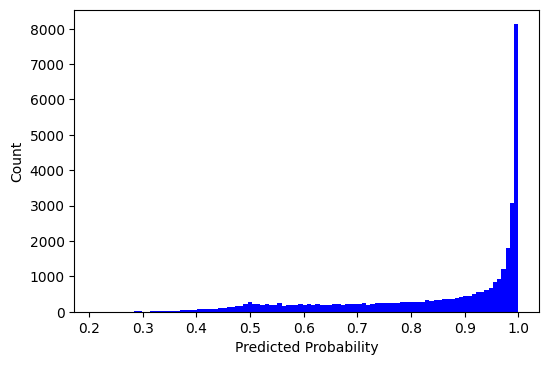

In [65]:
vals, idx = all_probs[~is_bg].max(dim=-1)
plt.hist(vals.numpy(), color='blue', bins=100, density=False);
plt.xlabel('Predicted Probability');
plt.ylabel('Count');

### For all boxes assigned to non-background, what is the histogram of the probability of the correct class?

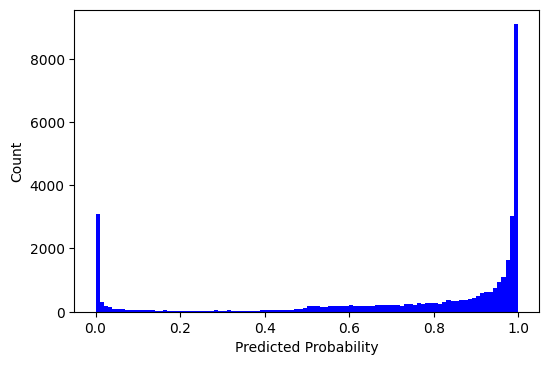

In [66]:
plt.hist(corr_probs[~is_bg].numpy(), color='blue', bins=100, density=False);
plt.xlabel('Predicted Probability');
plt.ylabel('Count');

### For all boxes assigned to background, what is the histogram of the probability of the most likely class?

In [ ]:
vals, idx = all_probs[is_bg].max(dim=-1)
plt.hist(vals.numpy(), color='blue', bins=100, density=False);
plt.xlabel('Predicted Probability');
plt.ylabel('Count');

### For all boxes assigned to background, what is the histogram of the probability of the correct class?

In [ ]:
vals, idx = all_probs[is_bg].max(dim=-1)
plt.hist(corr_probs[is_bg].numpy(), color='blue', bins=100, density=False);
plt.xlabel('Predicted Probability');
plt.ylabel('Count');